<a href="https://colab.research.google.com/github/nzahin04/pneumonia_classification/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

%matplotlib inline

In [2]:
from google.colab import files
from IPython.utils import io
import os
files.upload()
os.system("mkdir -p ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images


with io.capture_output() as captured:
    !unzip labeled-chest-xray-images.zip
    !rm labeled-chest-xray-images.zip

Saving kaggle.json to kaggle.json
 99% 1.16G/1.17G [00:33<00:00, 26.3MB/s]
100% 1.17G/1.17G [00:33<00:00, 37.5MB/s]


In [4]:
from torchvision.datasets import ImageFolder
means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225)

ImageNet_Normalization = transforms.Normalize(means, stds)

train_transforms = transforms.Compose([
            torchvision.transforms.RandomRotation(20),
            torchvision.transforms.RandomHorizontalFlip(p = 0.5), 
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            ImageNet_Normalization
])
test_transforms = transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            ImageNet_Normalization
])
training_dataset = ImageFolder('/content/chest_xray/train', transform = train_transforms)
test_dataset = ImageFolder('/content/chest_xray/test', transform = test_transforms)


In [7]:
training_dataset.class_to_idx.keys()

dict_keys(['NORMAL', 'PNEUMONIA'])

In [5]:
scan_labels = list(training_dataset.class_to_idx.keys())
textfile = open("scan_labels.txt", "w")
for element in scan_labels:
    textfile.write(element + "\n")
textfile.close()

In [8]:
from google.colab import files
files.download("scan_labels.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
valid_length = int(0.1 * len(training_dataset))
training_length = len(training_dataset) - valid_length
train_dataset,valid_dataset = torch.utils.data.random_split(training_dataset, [training_length, valid_length])

In [83]:
batch_size = 32
training_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)

In [84]:
model = torchvision.models.resnext101_32x8d(pretrained = True)
for parameters in model.parameters():
    parameters.requires_grad = False
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [85]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 1024), 
    torch.nn.Linear(1024, len(training_dataset.class_to_idx))

    )
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=2, bias=True)
)


In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
loss_fn = torch.nn.CrossEntropyLoss()

In [87]:
def train(num_epochs, dataloaders, datasets, model, optimizer, loss_fn, device, save_path):
    valid_min_loss = np.Inf
    train_losses = []
    valid_losses = []
    for epochs in range (1, num_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()

        for images, labels in dataloaders['train']:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.data

        model.eval()
        for images, labels in dataloaders['valid']:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            valid_loss += loss.data
        train_loss /= len(datasets['train'])
        valid_loss /= len(datasets['valid'])
        train_losses.append(train_loss.item())
        valid_losses.append(valid_loss.item())
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss {:.6f}'.format(epochs, train_loss, valid_loss))

        if valid_loss < valid_min_loss:
           print("Saving Model")
           torch.save(model.state_dict(), save_path)
           valid_min_loss = valid_loss
    
    return model, np.array(train_losses), np.array(valid_losses)

In [88]:
num_epochs = 10
dataloaders = {'train':training_dataloader, 'valid':valid_dataloader, 'test': test_dataloader}
datasets = {'train': training_dataset, 'valid': valid_dataset, 'test': test_dataset}
model, train_losses, valid_losses = train(num_epochs, dataloaders, datasets, model, optimizer, loss_fn, device, 'chest_xray_scan_model.pt')

Epoch: 1 	Training Loss: 0.011398 	Validation Loss 0.009404
Saving Model
Epoch: 2 	Training Loss: 0.006894 	Validation Loss 0.007086
Saving Model
Epoch: 3 	Training Loss: 0.005502 	Validation Loss 0.005960
Saving Model
Epoch: 4 	Training Loss: 0.005253 	Validation Loss 0.005403
Saving Model
Epoch: 5 	Training Loss: 0.004665 	Validation Loss 0.005309
Saving Model
Epoch: 6 	Training Loss: 0.004493 	Validation Loss 0.004754
Saving Model
Epoch: 7 	Training Loss: 0.004396 	Validation Loss 0.004555
Saving Model
Epoch: 8 	Training Loss: 0.003995 	Validation Loss 0.004852
Epoch: 9 	Training Loss: 0.003786 	Validation Loss 0.004263
Saving Model
Epoch: 10 	Training Loss: 0.003862 	Validation Loss 0.004379


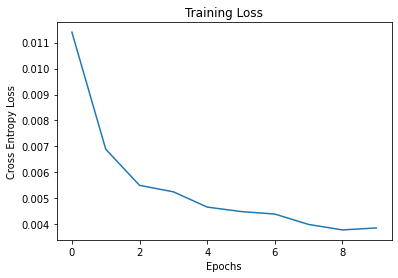

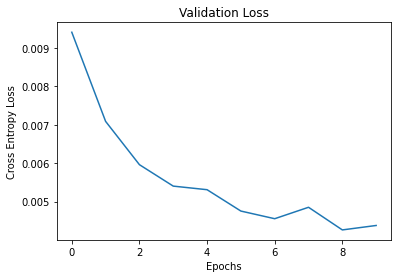

In [89]:
def plot_losses(losses, title):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.title(title)
    plt.show()

plot_losses(train_losses, title='Training Loss')
plot_losses(valid_losses, title='Validation Loss')


In [90]:
state_dict = torch.load('/content/chest_xray_scan_model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [91]:
def getPredsFromLogits(logits):
    return torch.nn.functional.softmax(logits, dim = 1).argmax(dim = 1)
def test(dataloaders, model, loss_fn, device):
    test_loss = 0.0
    count = 0
    total = 0

    model.eval()
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_fn(output, labels)
        test_loss += loss.data
        prediction = getPredsFromLogits(output)
        count += prediction.eq(labels).sum().item()
        total += prediction.shape[0]
        test_loss /= total
    print("Test Loss {:.6f}\n".format(test_loss))
    print("\nTest Accuracy: %2d%% (%2d/%2d)" % (100. * (count/total),count, total))



In [92]:
test(dataloaders, model, loss_fn, device)

Test Loss 0.000173


Test Accuracy: 90% (563/624)


In [94]:
from google.colab import files
files.download('chest_xray_scan_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>